## Requirements

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)


## Data Loading and Exploration

In [4]:
# load the dataset
heart_disease = fetch_ucirepo(id=45)

# Input / output
X = heart_disease.data.features
y = heart_disease.data.targets

print("\n--- Dataset Inspection ---")

# Shape of data
print(f"No. of samples (rows): {X.shape[0]}")
print(f"No. of features (columns): {X.shape[1]}")

# data types
print("\n--- Feature Info ---")
print(X.info())

# missing values
print("\n--- Missing Values per Column ---")
missing_values = X.isnull().sum()

# cols with missing values
print(missing_values[missing_values > 0])

# numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Numerical features:", numerical_features)

# label distribution
print("\n--- Target Distribution ---")

print(y.value_counts())


# For binary distribution 0 = healthy 1 = heart disease
y_binary = (y > 0).astype(int)  # Converts values >0 to 1, keeps 0 as 0

print("\n--- binary Distribution ---")
print(y_binary.value_counts())
print("(0: healthy, 1: disease):\n")


--- Dataset Inspection ---
No. of samples (rows): 303
No. of features (columns): 13

--- Feature Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None

--- Missing Values per Column ---
ca      4
thal    2
dtype: int64
Numerical features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',

## Data Preprocessing

In [6]:
# fix missing values
imputer = SimpleImputer(strategy='most_frequent')

# DataFrame to a numpy array
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values after imputation:\n", X_imputed.isnull().sum().sum())


# feature types
# numerical features
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# categorical features
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


# scaling - standardizing
scaler = StandardScaler()

X_imputed[num_cols] = scaler.fit_transform(X_imputed[num_cols])


# one-hot encoding (only categorical columns)
X_preprocessed = pd.get_dummies(X_imputed, columns=cat_cols, drop_first=False)

# new data shape
print("\nNew data shape:", X_preprocessed.shape)


# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, 
    y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary # balancing
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Missing values after imputation:
 0

New data shape: (303, 28)

Training set size: (242, 28)
Testing set size: (61, 28)


## Model Design: MLP

In [52]:
# MLP model
model = Sequential()

# 1st hidden layer
# 'input_shape=(X_train.shape[1],)': no. of features to expect
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

# 2nd hidden layer
model.add(Dense(units=32, activation='tanh'))

# 3rd hidden layer
#model.add(Dense(units=16, activation='relu'))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

# model architecture
model.summary()


# model compile
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# model train
print("\n--- Starting Training ---")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 50,
    batch_size=128,   # model updates weights after seeing 32 samples.
    verbose=1
)

c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Training ---
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6249 - loss: 0.6492 - val_accuracy: 0.6557 - val_loss: 0.6379
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6946 - loss: 0.6270 - val_accuracy: 0.7049 - val_loss: 0.6155
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7298 - loss: 0.6121 - val_accuracy: 0.7541 - val_loss: 0.5943
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7275 - loss: 0.5969 - val_accuracy: 0.7705 - val_loss: 0.5748
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7408 - loss: 0.5780 - val_accuracy: 0.8033 - val_loss: 0.5562
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7649 - loss: 0.5630 - val_accuracy: 0.8689 - val_loss: 0.5386
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7598 - loss: 0.5496 - val_accuracy: 0.8689 - val_loss: 0.5220
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7730 - loss: 0.5330 - val_accuracy

## Model Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy:  0.9016
Precision: 0.8667
Recall:    0.9286
F1-Score:  0.8966
ROC-AUC:   0.9719


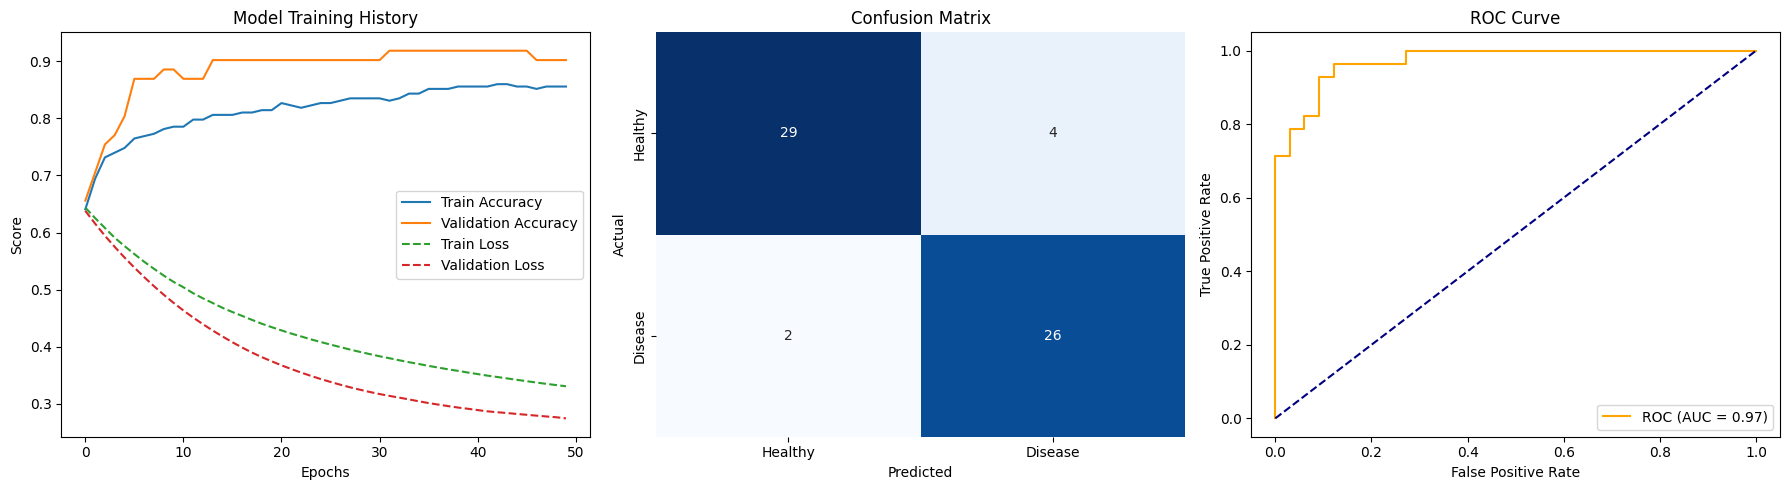

In [ ]:
# P(y_hat)
y_pred_probs = model.predict(X_test)

# y_hat
# P(y_hat) > 0.5 --> Disease (1) | P(y_hat) < 0.5 Healthy (0)
y_pred = (y_pred_probs > 0.5).astype(int)


# metrics
# accuracy
acc = accuracy_score(y_test, y_pred)
# precision
prec = precision_score(y_test, y_pred)
# recall
rec = recall_score(y_test, y_pred)
# f1-Score
f1 = f1_score(y_test, y_pred)
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")


# plots
# Set up a figure with 3 subplots (1 row, 3 columns)
plt.figure(figsize=(18, 5))

# training history (loss & accuracy)
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

# Confusion matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Healthy', 'Disease'],
            yticklabels=['Healthy', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC curve
plt.subplot(1, 3, 3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Random guess line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Baseline Comparison

In [ ]:
# logistic regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)



# predict class
y_pred_lr = lr_model.predict(X_test)
# predict probability
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]


# metrics
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_prob_lr)

print("Logistic Regression Results:")
print(f"Accuracy: {lr_acc:.4f}")
print(f"ROC-AUC:  {lr_auc:.4f}")

Logistic Regression Results:
Accuracy: 0.8852
ROC-AUC:  0.9665


c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Feature Selection and Model Interpretation

In [59]:
# shape matching
if hasattr(X_train, 'columns'):
    feature_names_list = X_train.columns
else:
    num_features = X_train.shape[1]
    feature_names_list = np.array([f"Feature_{i}" for i in range(num_features)])



k_values = [5, 10]

for k in k_values:
    print(f"\n" + "="*50)
    print(f"Top {k} Features")
    print("="*50)

    # feature selection
    selector = SelectKBest(score_func=f_classif, k=k)
    
    # fit selector
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # names of the selected features
    mask = selector.get_support()
    selected_features = feature_names_list[mask]
    
    print(f" -->  Selected Features: {list(selected_features)}")

    # model rebuild
    model_fs = Sequential([
        Dense(16, activation='relu', input_dim=k), 
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model_fs.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

    # model train
    model_fs.fit(X_train_selected, y_train, epochs=50, batch_size=10, verbose=0)

    # model evaluate
    y_probs_fs = model_fs.predict(X_test_selected, verbose=0)
    y_pred_fs = (y_probs_fs > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_fs)
    prec = precision_score(y_test, y_pred_fs)
    rec = recall_score(y_test, y_pred_fs)
    f1 = f1_score(y_test, y_pred_fs)
    auc = roc_auc_score(y_test, y_probs_fs)

    print(f"Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")


Top 5 Features
 -->  Selected Features: ['cp_4.0', 'exang_0.0', 'ca_0.0', 'thal_3.0', 'thal_7.0']


c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
Accuracy: 0.8852
Precision: 0.8889
Recall: 0.8571
F1-Score: 0.8727
ROC-AUC: 0.9340

Top 10 Features
 -->  Selected Features: ['thalach', 'oldpeak', 'cp_4.0', 'exang_0.0', 'exang_1.0', 'slope_1.0', 'slope_2.0', 'ca_0.0', 'thal_3.0', 'thal_7.0']


c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\Desktop\ANN\HW\HW1\Codes\Q4-venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
Accuracy: 0.9180
Precision: 0.8966
Recall: 0.9286
F1-Score: 0.9123
ROC-AUC: 0.9535
